# Integrating transcriptomics data to reconstruct cancer cell line models
**Authors:**
Thierry D.G.A Mondeel, Stefania Astrologo, Ewelina Weglarz-Tomczak & Hans V. Westerhoff <br/>
University of Amsterdam <br/>
2016 - 2018

In this part of the tutorial we will make use of the previously introduced human metabolic network (Recon 3) and apply cancer cell line transcriptomics to constrain the fluxes. 

**Objectives**
- Learn about ER+ cancer cell lines
- See an example of how (transcriptomics) data can be integrated with the human metabolic reconstruction
- Investigate if the data integrated network can teach you anything new about the cell lines

<span style="color:red">**Preliminary question:**</span>
What do you think: will the integration of transcriptomics and the metabolic network teach us more than the transcriptomics alone?

## Setting up the Python environment
<span style="color:red">**Assignment:**</span> Execute the cell below to set up our Python enviroment

In [1]:
# FBA tools
import cobra
from cobra.flux_analysis import pfba

# Pandas tables
import numpy as np
import pandas as pd # for tables
pd.set_option('display.max_colwidth', -1) # don't constrain the content of the tables
pd.options.display.max_rows = 9999

# import plotting capabilities
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Range1d
output_notebook() # Run once to get inline figuresimport matplotlib.pyplot as plt

import matplotlib
%matplotlib inline
from utils import show_map
import escher
map_loc = './maps/escher_map_RECON3D_energy_metabolism.json' # the escher map used below

# Load all required functions for the radar plot
from utils.file_list_function import file_list
from utils.flux_pattern_function import flux_pattern
from utils.df_plot_function import df_plot
from utils.flux_pie_plot_function import flux_pie_plot

# show all output in each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # all, last_expr

WT_r3_orig = cobra.io.load_json_model('models/Recon3D_301/Recon3DModel_301_simple_medium.json')

Loading BokehJS ...

## Introduction to ER+ Breast Cancer 
<span style="color:red">**Assignment (5 min):**</span> Read the following general overview about ER+ cancer subtypes and the 4 cell lines we will be investigating.

> <span style="color:blue">** About Breast Cancer**:</span>


>According to the **World Health Organization**, breast cancer is the most common cancer among women worldwide, claiming the lives of hundreds of thousands of women each year and affecting countries at all levels of modernization.

>There are **five** main intrinsic or **molecular subtypes** of breast cancer that are based on the genes a cancer cell expresses. 
<img src="images/BC_subtypes.png" width="600" height="600" align="center"/><br/>
[Click here to see the original Figure](https://doi.org/10.1371/journal.pmed.1000279.g001)




>Among the different molecular subtypes of breast cancer, **ER+ breast cancer comprises ~75% of all breast cancers**. Thus, the ER status has become the most important discriminator of breast cancer molecular subtypes, resulting in primary treatment options through targeting the estrogen synthesis or the ER functions (tamoxifen). This kind of treatment is generally known as endocrine therapy.

>--------
> <span style="color:blue">** About Breast Cancer Resistance**:</span>

> Although endocrine therapy has dramatically improved survival in breast cancer patients over the past several decades, **resistance** to these therapies remains one of the major causes of breast cancer mortality today. Late recurrence and death from estrogen receptor positive (ER+) breast cancer can occur for at least 20 years after the original diagnosis even after 5 years of adjuvant endocrine therapy. 

>Identifying mechanisms of resistance and strategies by which to combat these mechanisms is paramount to patient survival. [(Mills et al., 2018)](https://www.sciencedirect.com/science/article/pii/S147148921830002X?via%3Dihub)

>--------

> <span style="color:blue">** About endrocrine therapy in ER+ BC**:</span>
>



> Hormonal therapy medicines treat hormone-receptor-positive breast cancers in two ways:
- <span style="color:blue">- by **lowering** the amount of the hormone estrogen in the body;</span>
- <span style="color:blue">- by **blocking** the action of estrogen on breast cancer cells;</span>


>The main types of **endrocrine therapy** are the following: 
- Selective estrogen-receptor response modulators **(SERMs)**: <span style="color:red">tamoxifen</span>, Evista, Fareston
- Estrogen-receptor downregulators **(ERDs)**: <span style="color:orange">fulvestrant</span>
- Aromatase inhibitors **(AIs)**: anastrozole, exemestane, letrozole.

>--------

> <span style="color:blue">** About ER+ BC cell-lines**:</span>
>

>**MCF7** is a ER+ Breast Cancer cell-line (**Estradiol-dependent**) and sensitive to any treatment targeting the estrogen receptor network.

> <span style="color:red">**MCF7-T**</span> is a Tamoxifen resistent cell-line derived  from MCF7.

> <span style="color:orange">**MCF7-F**</span> is a Fulvestrant resistent cell-line derived  from MCF7.

> <span style="color:blueviolet">**LTED**</span> is a resistent cell-line, that recapitulates the Aromatase Inhibitor resistance (**Estradiol-independent**).

<img src="images/Cell_lines.png" width="600" height="600" align="center"/>

## The RNA-seq data on cancer cell lines: MCF7 and LTED

Here we will use transcriptomics data from [Nguyen et al. 2015](https://www.nature.com/articles/ncomms10044) for four breast cancer cell lines: LTED, MCF7, MCF7_F and MCF7_T.

Let's first have a look at the dataset

In [2]:
dataset = pd.read_pickle('models/Recon3D_301/Recon3_cell_line_models/data/total_dataset')
print('The dataset tracks:', len(dataset), 'genes that encode metabolic enzymes.')
dataset.head()

The dataset tracks: 2290 genes that encode metabolic enzymes.


,MCF7,MCF7_F,MCF7_T,LTED
entrez_id,,,,
0.0,0.000000,0.000000,0.000000,0.000000
13.1,0.129984,0.000000,0.080061,0.087407
15.1,0.000000,0.058408,0.059831,0.032661
18.1,36.980706,5.672655,5.680825,34.087925
18.2,36.980706,5.672655,5.680825,34.087925


<span style="color:red">**Assignment:**</span> Based on the histogram plot below, how many genes are roughly not expressed in each cell line? Note that you will not see the actual number of exact zeros (due to the bins).

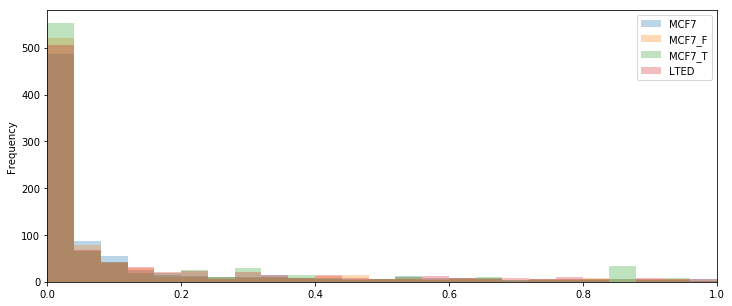

In [3]:
sub_dataset = dataset[dataset < 1] # zoom in on low expression genes
sub_dataset.plot(kind='hist',xlim=[0,1],bins=25,alpha=0.3,figsize=(12,5))

<span style="color:red">**Assignment:**</span> Now confirm your answer above by looking at the percentage of actual zeros below. Is the percentage surprising to you? Might these all be the same enzymes since all four cell lines are cancer cell lines?

In [4]:
(dataset < 1e-3).sum(axis=0)/len(dataset)*100

MCF7      18.602620
MCF7_F    20.349345
MCF7_T    22.620087
LTED      17.729258
dtype: float64

Let's investigate if there are real differences between the cell lines. The bar plot below is useful to see expression level differences between the cell lines .

<span style="color:red">**Assignment:**</span> Are you convinced based on this plot and the number of unexpressed genes that the cell lines are really different metabolically? Or is the expression level very similar?

Lookin only at the 34 genes that show relatively high transcript levels out of a total of 2290 genes


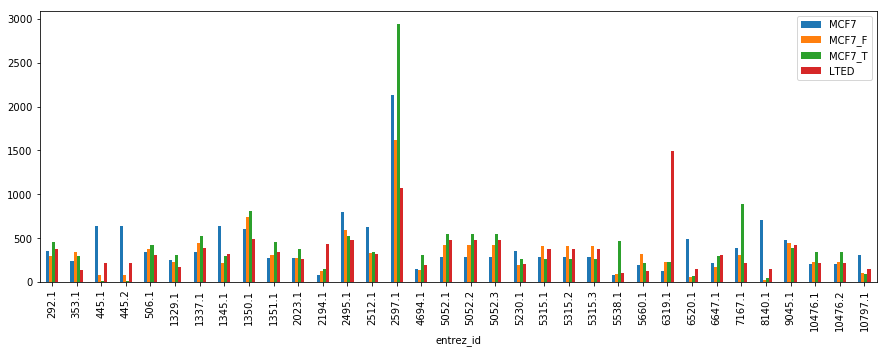

In [5]:
subdataset = dataset[(dataset.T > 300).any()] # zoom in on genes with reasonably high transcript levels
print('Lookin only at the',len(subdataset),'genes that show relatively high transcript levels out of a total of', len(dataset),'genes')
subdataset.plot(kind='bar',figsize=(15,5))

<span style="color:red">**Assignment:**</span> The plot below zooms in on genes not expression in some cell lines but expressed in others. Is this more convincing?

Lookin only at the 43 genes that show relatively high transcript levels out of a total of 2290 genes


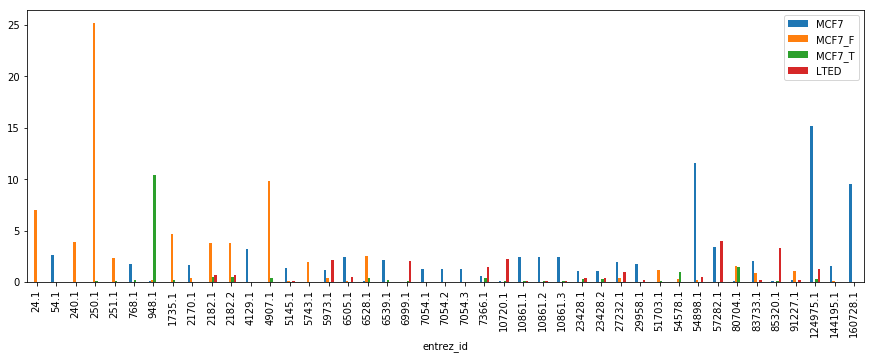

In [6]:
# zoom in on genes that show no expression in some cell lines and some expression in others
subdataset = dataset[(dataset.T == 0).any() & (dataset.T > 1).any()] 
print('Lookin only at the',len(subdataset),'genes that show relatively high transcript levels out of a total of', len(dataset),'genes')
subdataset.plot(kind='bar',figsize=(15,5))

<span style="color:red">**Assignment:**</span> Do the numerical FPKM values plotted above convince you that there might be some differences between the cell lines?

Let's now investigate if these differences matter for the flux pattern capabilities of the cell lines...

## Mapping transcriptomic data to Recon3D
Our approach for integrating the transcriptomics data with the metabolic network is based on [Damiani et al. 2018](https://www.biorxiv.org/content/early/2018/01/30/256644). This approach was originally devised to deal with single cell transcriptomics but is here modified to apply across different cell lines. We will explain the details below, but beware as the details can be tricky to understand if you are new to flux balance analysis. Don't despair! You do not have to understand it 100%. 

### The approach in a nutshell
The key idea is to normalize each gene's transcriptomic level by the sum total across all four cell lines. This leads to transcriptomics "score" between 0 and 1. 0 if the transcript level is 0 in a particular cell line and 1 if that cell line was the only one to have any expression. 

We then take the unconstrained Recon 3 model and determine for each reaction what the maximal flux is that it can sustain on the defined medium. That maximal flux is then multiplied by the transcriptomics score and this product is set as the maximal flux bound in the model.

**The outcome of this is that each reaction will have a flux bound that is proportional (i.e. linearly related) to the transcriptomics score.** 

<span style="color:red">**Discuss:**</span> Can you think of an argument for why this approach of assuming a linear relationship between flux and transcript levels is reasonable? 


<span style="color:red">**Discuss:**</span> Can you  think of a reason for why our approach is probably inaccurate? How would you go about improving this if you were in the business of systems biology research?

### The details: two thorny problems (feel free to skip if you're in a hurry or don't care)
What the above fails to mention is that we (1) need to account for isoenzymes and enzyme complexes and (2) that we need to deal with completely untranscribed genes which can wreak havoc on our model. 

- (1) The former is dealt with by summing op transcriptomic scores across isoenzymes for each reaction and taking the minimum transcriptomics score for components of an enzyme complex for each reaction. 
- (2) is solved by not setting reactions to zero if there is no transcript levels detected, but rather to a very low flux bound 1e-3. This way we will still be able to see bottlenecks (their flux will hit the 1e-3 bound) but we ensure that the model will keep functioning at all times (no pathways will be fully blocked).

## Analyzing pre-prepared cancer cell line models
We applied the approach detailed above and saved the constrained cell lines for you. We will analyze them below.  

## Load the models
Start by loading the models using the cell below. This will take a minute or so. 

In [ ]:
files = ["LTED_FPKM.json", "MCF7_FPKM.json", "MCF7_T_FPKM.json", "MCF7_F_FPKM.json"]

LTED_orig = cobra.io.load_json_model('./models/Recon3D_301/Recon3_cell_line_models/LTED_FPKM.json')
MCF7_orig = cobra.io.load_json_model('./models/Recon3D_301/Recon3_cell_line_models/MCF7_FPKM.json')
MCF7_F_orig = cobra.io.load_json_model('./models/Recon3D_301/Recon3_cell_line_models/MCF7_F_FPKM.json')
MCF7_T_orig = cobra.io.load_json_model('./models/Recon3D_301/Recon3_cell_line_models/MCF7_T_FPKM.json')

# Save unaltered copies of each model
WT_r3 = WT_r3_orig.copy()
LTED = LTED_orig.copy()
MCF7 = MCF7_orig.copy()
MCF7_F = MCF7_F_orig.copy()
MCF7_T = MCF7_T_orig.copy()

## Analyzing the growth rates
<span style="color:red">**Assignment:**</span> The cell below prints the growth rate (calculated using Flux Balance Analysis) for the unconstrained Recon 3 model and each of the four cell lines. Do the results make sense? Do you notice anything interesting?

In [ ]:
growth_rate_dict = {}
for model_name,model in [('WT Recon 3',WT_r3), ('LTED',LTED), ('MCF7',MCF7), ('MCF7_F',MCF7_F), ('MCF7_T',MCF7_T)]:
    sol = model.optimize()
    growth_rate_dict[model_name] = round(sol.fluxes['biomass_reaction'],5)

pd.DataFrame.from_dict(growth_rate_dict,orient='index', columns=['Growth rate'])

**Possible observations**
- All cell lines growth rates are lower than the unconstrained Recon 3 model, i.e. the transcriptomics constraints are actually constraining the flux patterns
- The cell lines are not all the same metabolically (based on the applied methodology)
- MCF7 (the non-resistant) cell line outperforms the other cell lines in terms of growth rate
- It appears that MCF7_F and MCF7_T have similar growth rates. 

<span style="color:red">**Assignment:**</span> Could you have gotten this insight, into the potential effect of transcript limitations on growth rate, from just the transcriptomics? This is the power of 'Systems Thinking'.

##  More detailed analysis of flux distribution across metabolic subsystems
Recon 3 comes annotated with a so-called "metabolic subsystem" for many reactions. These subsystems reflect the major pathway that a reaction is a part of, e.g.: glycolysis, the TCA cycle, cholesterol synthesis etc.

The cell below will perform flux balance analysis on all four cell lines and plot the total flux running through a selected number of subsystems. This will give an indication of the metabolic pathways each cell line is using to grow.

<span style="color:red">**Assignment:**</span> Execute the cell below (wait up to a minute or so for the calculations to complete) and investigate the output. Do you observe any interesting patterns?

In [ ]:
# list of model's files
files  = file_list('models/Recon3D_301/Recon3_cell_line_models/')

f_pattern = flux_pattern(files, analysis = 'FBA')

target_ss = [
    ['Glycolysis/gluconeogenesis','Central Carbon Metabolism'],
    ['Citric acid cycle','Central Carbon Metabolism'],
    ['Oxidative phosphorylation','Central Carbon Metabolism'],
    ['Pentose phosphate pathway','Central Carbon Metabolism'],
    ['Pyruvate metabolism','Central Carbon Metabolism'],
    ['Fatty acid oxidation','Peripheral metabolism'],
    ['Squalene and cholesterol synthesis','Peripheral metabolism'],]
#     ['Steroid metabolism','Peripheral metabolism'],
#     ['Glutathione metabolism','Peripheral metabolism']
    
# ]

df  = df_plot(target_ss, f_pattern)
flux_pie_plot(df)

Now we perform the same analysis using parsimonious FBA. p(arsimonious)FBA finds the shortest pathway to optimal growth in terms of the total flux for each cell line. I.e. it will tend to return flux patterns that are efficient in terms of the amount of enzyme needed to support it. Will we see the same behavior? 

<span style="color:red">**Assignment:**</span> Execute the cell below (wait up to a minute or so for the calculations to complete) and compare the output from pFBA with that of FBA. Are they similar? 

In [ ]:
# list of model's files
files  = file_list('models/Recon3D_301/Recon3_cell_line_models/')

f_pattern = flux_pattern(files, analysis = 'pFBA')

target_ss = [
    ['Glycolysis/gluconeogenesis','Central Carbon Metabolism'],
    ['Citric acid cycle','Central Carbon Metabolism'],
    ['Oxidative phosphorylation','Central Carbon Metabolism'],
    ['Pentose phosphate pathway','Central Carbon Metabolism'],
    ['Pyruvate metabolism','Central Carbon Metabolism'],
    ['Fatty acid oxidation','Peripheral metabolism'],
    ['Squalene and cholesterol synthesis','Peripheral metabolism'],]
#     ['Steroid metabolism','Peripheral metabolism'],
#     ['Glutathione metabolism','Peripheral metabolism']
    
# ]

df  = df_plot(target_ss, f_pattern)
flux_pie_plot(df)

## WT Recon 3 vs. cell lines: The Warburg effect
Finally, we will use FVA to ascertain essentiality of certain reactions for the optimal growth condition in each cell line and investigate the Warburg effect. 

### Cancer, a-socialism and the Warburg effect
One way to think of cancer cells is that these will behave a-socially: i.e. like unicellular organism within the multicellular one: tumors. 

It has been observed that such cells, in contrast to healthy, social cells, are characterized by growing on a low ATP/glucose ratio (the Warburg effect): Glucose + 2 ADP => lactate + 2 ATP (fermentation) instead of: Glucose + 32 ADP =>  6 CO2 + 32 ATP (respiration). 

[See this Wiki page about the Warburg effect](https://en.wikipedia.org/wiki/Warburg_effect) and the [original publication by Otto Warburg (1956)](http://science.sciencemag.org/content/123/3191/309).

### Applying FVA to the cell lines
Remember that with FVA (Flux Variability Analysis) we can find out the range of flux through a reaction that is possible while the cell still grows optimally! This will allow us to see if, for instance, oxygen uptake is essential for these cancer cells.

<span style="color:red">**Assignment:**</span> The cell below performs FVA for a variety of reactions representing: oxygen uptake, proton pumping through the ATPase (final step in respiration), glycolysis (PGK/PYK), glucose uptake, non-essential amino acids (glutamate and glutamine uptake), essential amino acids (phenylalanine), lactate production. 

Each of these reactions, for each cell line and the unconstrained Recon 3, is associated with an interval that represents the lowest and highest possible flux possible while the cell is able to achieve optimal growth rate. 

Inspect the output. Pay particular attention to see if you can spot presence or absence of the Warburg effect. 

Then, read our observations further down the page.

In [ ]:
interesting_rxns = ['EX_o2_e',
                    'ATPS4mi','PGK','PYK', # ATP production
                    'EX_glc_D_e','EX_glu_L_e','EX_gln_L_e','EX_phe_L_e', # carbon sources
                    'EX_lac_L_e'
                   ]

df = pd.DataFrame()
d = {}

modelnames = ['WT Recon 3','MCF7','MCF7_F','MCF7_T','LTED']
for i,model in enumerate([WT_r3, MCF7, MCF7_F, MCF7_T, LTED]):
    
    model.reactions.EX_lac_D_e.upper_bound = 0 # keep one lactate exit
    
    fvasol = cobra.flux_analysis.flux_variability_analysis(model,reaction_list=interesting_rxns,
                                                           fraction_of_optimum=1)
    
    parsed_res = {r:[round(fvasol.loc[r]['minimum'],3),round(fvasol.loc[r]['maximum'],3)] for r in fvasol.index }
    d[modelnames[i]] = parsed_res
    
df = pd.DataFrame(d,index=interesting_rxns,columns=modelnames)
df.to_csv('FVA_comparison_cell_lines_vs_WT.csv',sep='\t')
df

**Possible observations:**
- Positive controls: some oxygen and essential amino acid uptake is needed for growth in all cell lines (see O2 and phenylalanine rows). This may be seen by the negative lower bounds.

- Cancer cell lines shift toward fermentation (Warburg effect): In the WT the optimal growth rate requires proton pumping (ATPS4mi). The optimal growth rate is not dependent on proton pumping in the 4 cell lines suggesting a shift to fermentation vs. respiration. This can be observed based on the zero lower bound for ATPS4mi. 
- All 4 cell lines tend to secrete more lactate than the WT Recon 3 (see the lactate uper bound).
- Compnents of the ATPase are not expressed in MCF7 and MCF7_T: note that the upper bound on ATPS4mi in MCF7 and MCF7_T equals 0.001. 0.001 is the minimum reaction bound we enforced during the transcriptomic mapping. This is therefore likely due to one or more components of the complex not being expressed. 
- MCF7 and MCF7_T require glucose uptake to grow optimally, like the WT, but more severe. LTED and MCF7_F do not. This also indicates MCF7 and MCF7_T are likely to at least partly ferment. Whereas MCF7/F and LTED tend to at least partially make use of respiration.

# Wrap up
Hopefully this tutorial taught you something about the power of systems biology, systems and deep thinking. You now grasp the basics of flux balance/variability analysis, experienced using Python programming for science and saw one way of integrating real data in a computational model. Hopefully, you are convinced that $$\text{data} + \text{model} > \text{data alone}$$

This is only one (limited) example of the power of computational systems biology. The ultimate challenge is for you to now translate this to you own problem of interest! Hopefully this tutorial inspired you to do so.